对深度学习来说， 模型未动， 数据先行。 在实际应用过程中， 训练用的数据集都很大， 不能一次性加载到内存， 需要使用高效的方式来进行数据的I/O。 常见的方式有两种：
* 使用高效的存储格式， 例如lmdb， h5py，tfrecord等
* 使用多线程读取并预处理数据

前者一般是自己处理， 将文件系统中的数据转存成h5或tfrecord文件。 起码个人是这样的， 而且因h5文件读写的方便性， 个人更倾向于使用h5文件。 根据个人经验， 如果I/O是训练过程的瓶颈， 相比于直接从操作系统的文件系统（File System, FS)读取数据， 使用h5文件存储再读取， 可提速20%到30%左右。  
后者也可以自己实现， 但更方便的做法是使用训练框架提供的数据I/O接口。 Tensorflow的第一个版本， 前期主要使用多线程队列的接口， 后来则提供更方便使用的`tf.data.Dataset`接口。 到2.0版本中， 继续使用`Dataset`接口。

本文使用cifar10作为试验对象来说明`Dataset`的用法。 本身很小， 一下子加载到内存中也不怎么占资源， 但还是使用`Dataset`接口来处理它。

# 加载CIFAR-10数据
`keras`是tensorflow2.0里使用的高级API， 它提供了现成的常用小数据集下载和加载接口， 方便使用。 

In [1]:
import tensorflow as tf
assert tf.__version__ >= '2.0'
from tensorflow import keras
cifar10 = keras.datasets.cifar10
(X_train_full, Y_train_full), (X_test, Y_test) = cifar10.load_data()
print(X_train_full.shape, Y_train_full.shape)
print(X_test.shape, Y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


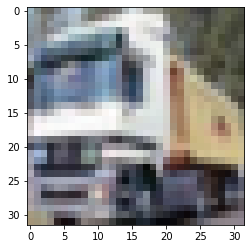

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(X_train_full[1, ...])

# 使用Dataset接口
因为我自己也是刚开始学习tensorflow2， 掌握的特性与API有限， 本文只介绍一种可行且个人认为比较方便的数据I/O流程， 主要步骤如下：
* 实现一个生成器（generator)读取数据
* 使用`tf.data.Dataset.from_generator`方法创建`Dataset`对象
* 使用`Dataset`的`map_func`等方法对数据进行预处理、shuffle、生成mini-batch、预加载等

## 实现用于数据解析和读取的生成器

In [3]:
def gen():
    num_examples = X_train_full.shape[0]
    for idx in range(num_examples):
        yield idx, X_train_full[idx, ...], Y_train_full[idx] # 通过返回的idx确定看出后面的shuffle确实发挥了作用

使用Python的原生代码， 可以很方便的解析任何格式的数据， 如果不考虑I/O效率， 可不用生成中间文件， 节省磁盘空间。 数据的预处理可以写在这个函数里：用原生Python实现， 可方便的调用numpy和cv2的接口， 也可以写在后面， 使用tensorflow提供的接口。
## 使用tf.data.Dataset.from_generator方法创建Dataset对象

In [4]:
image_shape = X_train_full.shape[1:]
dataset = tf.data.Dataset.from_generator(generator = gen, 
                 output_types = (tf.int32, tf.uint8, tf.int32), 
                 output_shapes = ((), image_shape, (1,)))


## 数据进行预处理、shuffle、生成mini-batch和预加载

In [5]:
# 预处理函数
def tf_preprocess(idx, img, label):
    img = tf.cast(img, tf.float32)
    # ...
    img = img / 255.0
    return idx, img, label

dataset = dataset.map(map_func = tf_preprocess, num_parallel_calls = 12)
dataset = dataset.shuffle(buffer_size = 50)
dataset = dataset.batch(batch_size = 2)

最后， 验证一下数据I/O的结果。Tensorflow2.0默认使用Eager模式， 不需要创建Session， 直接对Dataset进行迭代。

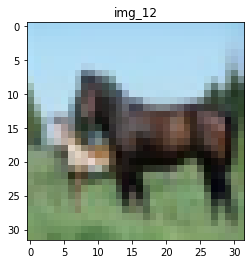

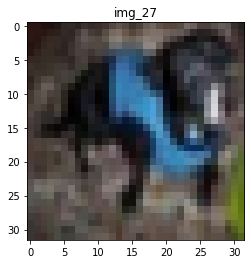

In [6]:
import numpy as np
for iteration, (img_idxes, imgs, labels) in enumerate(dataset):
    if iteration < 1:
        img_idxes = img_idxes.numpy()
        imgs = np.asarray(imgs.numpy() * 255.0, dtype = np.uint8)
        labels = labels.numpy()
        for img_idx, img, label in zip(img_idxes, imgs, labels):
            plt.figure()
            plt.title("img_%d"%(img_idx))
            plt.imshow(img)
        